In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import sys
sys.path.append('GAN')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
import numpy as np
from tensorflow.keras.datasets import mnist

### Load data

In [2]:
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 1s 0us/step


### Utility function

In [3]:
import scipy
import moviepy.editor as mpy
def visualize_imgs(imgs, shape, save_path=None):
    (row, col) = shape[0], shape[1]
    height, width = imgs[0].shape[:2]
    total_img = np.zeros((height*row, width*col))
    for n, img in enumerate(imgs):
        j = int(n/col)
        i = n%col
        total_img[j*height:(j+1)*height,i*width:(i+1)*width] = img
    if save_path is not None:
        scipy.misc.imsave(save_path, img)
    return total_img

def make_gif(images, fname, duration=2, true_image=False):
    def make_frame(t):
        try:
            x = images[int(len(images)/duration*t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x+1)/2*255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.write_gif(fname, fps = len(images) / duration)
def iter_data(*data, **kwargs):
    size = kwargs.get('batch_size', 128)
    try:
        n = len(data[0])
    except:
        n = data[0].shape[0]
    batches = int(n / size)
    if n % size != 0:
        batches += 1
    for b in range(batches):
        start = b * size
        end = (b + 1) * size
        if end > n:
            end = n
        if len(data) == 1:
            yield data[0][start:end]
        else:
            yield tuple([d[start:end] for d in data])        

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.032768/45929032 bytes (0.1%81920/45929032 bytes (0.2%294912/45929032 bytes (0.6425984/45929032 bytes (0.9573440/45929032 bytes (1.2688128/45929032 bytes (1.5835584/45929032 bytes (1.8933888/45929032 bytes (2.01048576/45929032 bytes (2.3%1146880/45929032 bytes (2.5%1261568/45929032 bytes (2.7%1343488/45929032 bytes (2.9%1425408/45929032 bytes (3.1%1507328/45929032 bytes (3.3%1613824/45929032 bytes (3.5%1695744/45929032 bytes (3.7%1810432/45929032 bytes (3.9%1875968/45929032 bytes (4.1%1941504/45929032 bytes (4.2%2007040/45929032 bytes (4.4%2056192/45929032 bytes (4.5%2138112/45929032 bytes (4.7%2220032/45929032 bytes (4.8%2301952/45929032 bytes (5.0%2383872/45929032 bytes (5.2%2465792/45929032 bytes (5.4%2564096/45929032 bytes (5.6%2662400/45929032 bytes 

In [4]:
#IWGAN
class IWGAN(object):
    def __init__(self, image_size, image_channel, z_dim=128, learning_rate=1e-4, lamda=10, beta1=0, beta2=0.9):
        self.image_size = image_size
        self.image_channel = image_channel
        self.z_dim = z_dim
        self.learning_rate = learning_rate
        self.lamda = lamda
        self.beta1=beta1
        self.beta2=beta2
        self.build_model()

    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size,
                                              self.image_size, self.image_channel])

        # create generator
        self.image_fake = self.generator()

        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)

        # loss of discriminator
        self.d_loss_real = tf.reduce_mean(self.logit_real)
        self.d_loss_fake = tf.reduce_mean(self.logit_fake)
        #epsilon
        epsilon = tf.random_uniform([], 0.0, 1.0)
        x_h = epsilon*(self.image_real) + (1-epsilon)*self.image_fake
        pred_x_hat, logit_x_hat = self.discriminator(x_h)
        dx = tf.gradients(logit_x_hat, x_h)[0]
        dx = tf.sqrt(tf.reduce_sum(tf.square(dx), axis=1))
        temp_loss = self.lamda*(tf.square(dx-1))
        temp_loss = tf.reduce_mean(temp_loss)
        self.d_loss = self.d_loss_fake - self.d_loss_real + temp_loss

        # loss of generator
        self.g_loss = -tf.reduce_mean(self.logit_fake)

        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate,
                                                  beta1=self.beta1, beta2=self.beta2).minimize(self.d_loss,var_list=self.d_vars)

        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate,
                                                  beta1=self.beta1, beta2=self.beta2).minimize(self.g_loss,var_list=self.g_vars)

    def discriminator(self, image):
        lrelu = tf.nn.leaky_relu
        conv2d = tf.layers.conv2d
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
            if self.image_channel==1:
                image = tf.reshape(image, [-1, self.image_size, self.image_size, 1])
            hidden = self.z
            hidden = image
            hidden = lrelu(conv2d(hidden, 32, kernel_size=5, strides=2, padding='same'))
            hidden = lrelu(bn(conv2d(hidden, 128, kernel_size=5, strides=2, padding='same'),
                              training=True))
            hidden = tf.layers.flatten(hidden)
            hidden = lrelu(bn(linear(hidden, 1024), training=True))
            hidden = linear(hidden, 1)
            return tf.nn.sigmoid(hidden), hidden

    def generator(self, y=None):
        relu = tf.nn.relu
        deconv2d = tf.layers.conv2d_transpose
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope("generator"):
            self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')
            hidden = self.z
            hidden = relu(bn(linear(hidden, 1024), training=True))
            hidden = relu(bn(linear(hidden, (self.image_size//4)*(self.image_size//4)*128),
                             training=True))
            hidden = tf.reshape(hidden, [-1, self.image_size//4, self.image_size//4, 128])
            hidden = relu(bn(deconv2d(hidden, 32, kernel_size=5, strides=2, padding='same'),
                             training=True))
            hidden = tf.nn.sigmoid(deconv2d(hidden, self.image_channel, kernel_size=5,
                                            strides=2, padding='same'))
            if self.image_channel==1:
                hidden = tf.reshape(hidden, [-1, self.image_size, self.image_size])
            return hidden

    def train(self, sess, x_train, num_epoch=100, batch_size=100, num_sample=100,
              show_samples=True, sample_path='./samples', n_critic=5, log=False):
#        print("----- in training -----")
        # sample some random noise, these noise is used to monitor generated image
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        start_time = time.time()
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []

            for batch_images in iter_data(x_train, batch_size=batch_size):
                for counter in range(0,n_critic):
                    batch_z = np.random.uniform(-1, 1,[batch_size, self.z_dim]).astype(np.float32)
                    # Update D network
                    feed_dict={self.image_real: batch_images,self.z: batch_z}
                    d_loss, _ = sess.run([self.d_loss, self.d_update_op], feed_dict=feed_dict)
                    d_losses.append(d_loss)
                # Update G network
                batch_z = np.random.uniform(-1, 1,[batch_size, self.z_dim]).astype(np.float32)
                g_loss, _ = sess.run([self.g_loss, self.g_update_op], feed_dict={self.z: batch_z})
                g_losses.append(g_loss)
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20),
                                 save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)

            if (epoch+1) % 10 == 0:
                if show_samples:
                    plt.imshow(img, cmap = 'gray')
                    plt.axis('off')
                    plt.title('epoch {}'.format(epoch+1))
                    plt.show()
        return sample_imgs, d_loss_epoch, g_loss_epoch

    def save_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name), global_step=step)
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))

    def load_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name+'-{}'.format(step)))
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))
            

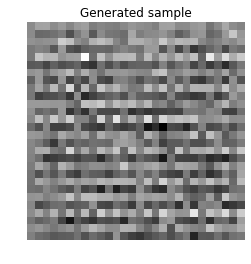

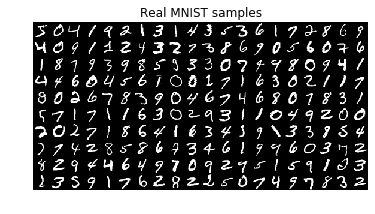

In [5]:
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
iwgan = IWGAN(image_size=28, image_channel=1, learning_rate=1e-4)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sample_z = np.random.uniform(-1, 1, size=(200 , iwgan.z_dim))
samples = sess.run(iwgan.image_fake, feed_dict = {iwgan.z: sample_z})
plt.imshow(samples[0].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()
samples = x_train[:200]
img = visualize_imgs(samples, shape=(10,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

### Start training

----- start training -----
Epoch: [0] time: 69.07, d_loss: -0.6311, g_loss: -5.0988
Epoch: [1] time: 136.48, d_loss: -5.7966, g_loss: -17.0346
Epoch: [2] time: 205.53, d_loss: -6.4772, g_loss: -38.9225
Epoch: [3] time: 273.40, d_loss: -4.7561, g_loss: -59.1427
Epoch: [4] time: 342.12, d_loss: -3.9266, g_loss: -65.7424
Epoch: [5] time: 410.29, d_loss: -3.6965, g_loss: -68.4149
Epoch: [6] time: 477.91, d_loss: -3.3665, g_loss: -67.1047
Epoch: [7] time: 545.73, d_loss: -2.9542, g_loss: -65.1021
Epoch: [8] time: 614.19, d_loss: -2.1330, g_loss: -62.7046
Epoch: [9] time: 683.04, d_loss: -2.4328, g_loss: -65.6771


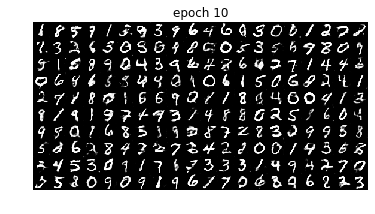

Epoch: [10] time: 751.75, d_loss: -2.3729, g_loss: -65.3605
Epoch: [11] time: 820.12, d_loss: -1.8472, g_loss: -64.4109
Epoch: [12] time: 887.90, d_loss: -2.1639, g_loss: -65.1807
Epoch: [13] time: 955.49, d_loss: -1.7548, g_loss: -60.5243
Epoch: [14] time: 1023.23, d_loss: -1.0876, g_loss: -51.1472
Epoch: [15] time: 1090.73, d_loss: -0.8318, g_loss: -43.9496
Epoch: [16] time: 1158.42, d_loss: -0.4379, g_loss: -38.8243
Epoch: [17] time: 1227.47, d_loss: -0.6350, g_loss: -39.0134
Epoch: [18] time: 1295.10, d_loss: -0.6901, g_loss: -36.4450
Epoch: [19] time: 1362.63, d_loss: -0.6923, g_loss: -32.7211


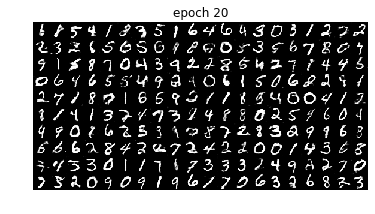

Epoch: [20] time: 1431.37, d_loss: -0.6528, g_loss: -28.7600
Epoch: [21] time: 1499.06, d_loss: -0.6786, g_loss: -24.2034
Epoch: [22] time: 1566.48, d_loss: -0.6572, g_loss: -19.2820
Epoch: [23] time: 1634.40, d_loss: -0.4637, g_loss: -13.8404
Epoch: [24] time: 1702.00, d_loss: -0.6784, g_loss: -14.5829
Epoch: [25] time: 1769.56, d_loss: -0.9455, g_loss: -20.6335
Epoch: [26] time: 1837.32, d_loss: -0.9440, g_loss: -24.2097
Epoch: [27] time: 1904.74, d_loss: -0.9034, g_loss: -25.3335
Epoch: [28] time: 1972.53, d_loss: -0.6545, g_loss: -20.3354
Epoch: [29] time: 2039.86, d_loss: -0.5127, g_loss: -16.3298


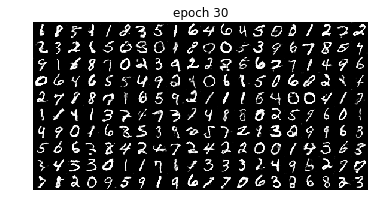

Epoch: [30] time: 2108.73, d_loss: -0.9821, g_loss: -19.4925
Epoch: [31] time: 2176.38, d_loss: -1.0257, g_loss: -22.3473
Epoch: [32] time: 2243.82, d_loss: -0.9515, g_loss: -22.7392
Epoch: [33] time: 2311.40, d_loss: -0.9914, g_loss: -22.3899
Epoch: [34] time: 2378.81, d_loss: -0.9924, g_loss: -23.2032
Epoch: [35] time: 2446.50, d_loss: -0.9707, g_loss: -22.9152
Epoch: [36] time: 2514.16, d_loss: -0.8784, g_loss: -21.7086
Epoch: [37] time: 2581.76, d_loss: -0.8827, g_loss: -21.6001
Epoch: [38] time: 2649.42, d_loss: -0.9525, g_loss: -23.3577
Epoch: [39] time: 2716.86, d_loss: -0.9784, g_loss: -23.8866


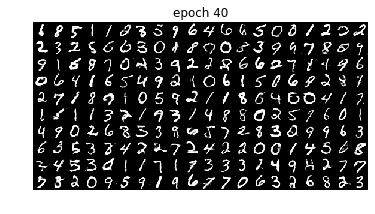

Epoch: [40] time: 2785.85, d_loss: -1.0003, g_loss: -24.1505
Epoch: [41] time: 2853.39, d_loss: -0.9903, g_loss: -23.3832
Epoch: [42] time: 2920.91, d_loss: -1.0206, g_loss: -23.3733
Epoch: [43] time: 2988.48, d_loss: -1.0462, g_loss: -23.5467
Epoch: [44] time: 3057.22, d_loss: -1.0806, g_loss: -24.0736
Epoch: [45] time: 3124.97, d_loss: -1.0468, g_loss: -24.4424
Epoch: [46] time: 3192.33, d_loss: -1.0358, g_loss: -24.7804
Epoch: [47] time: 3261.48, d_loss: -0.9915, g_loss: -24.3775
Epoch: [48] time: 3328.82, d_loss: -1.0775, g_loss: -24.2422
Epoch: [49] time: 3397.17, d_loss: -1.0864, g_loss: -24.5089


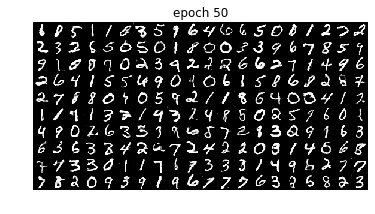

In [6]:
print("----- start training -----")
sample_imgs, d_loss_epoch, g_loss_epoch = iwgan.train(sess, x_train, num_sample=200, num_epoch=50, n_critic=5, log=True)

### Plot

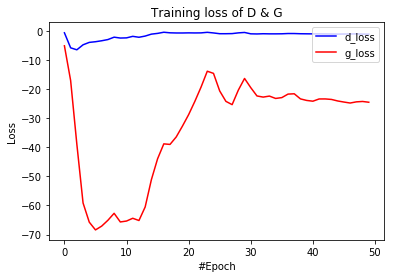

In [7]:
plt.plot(range(len(d_loss_epoch)), d_loss_epoch, color = 'blue', label = 'd_loss')
plt.plot(range(len(g_loss_epoch)), g_loss_epoch, color = 'red', label = 'g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

### Make GIF

In [9]:
imgs = np.array(sample_imgs)
make_gif(imgs*255., 'iwgan.gif', true_image=True, duration=2)
from IPython.display import Image
Image(url='iwgan.gif')



[MoviePy] Building file iwgan.gif with imageio


 98%|█████████▊| 50/51 [00:00<00:00, 89.35it/s]


# Report

### 1. Brief report about what I have done

在這次的作業中，我前面照著助教的code，用助教wgan的部分進行修改，首先是多傳入一些需要的參數，包括lamda、beta1以及beta2，接著loss和optimizer的部分照著notebook上給的algorithm進行修改，最後是在train的部分，我把iter_data中跑n_critic的部分改成迴圈，每次都做batch_z和d_loss的更新，做完一個n_critic的巡迴後再產生一次batch_z，然後更新g_loss，最後plot出d_loss和g_loss，以及做出gif。

### 2. Come up or survey some applications of GAN

GAN的現在非常主流，應用非常的多，像是:
##### 1.)Pose Guided Person Image Generation
        -A Variational U-Net for Conditional Appearance and Shape Generation:這是CVPR2018的paper，可以選擇情況控制object的appearance和shape，原理就是利用GAN的想法。
##### 2.)CycleGAN
        -Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks
        CycleGAN可以用在圖片的轉換，像是把一張圖片變成不同畫風，或是變成不同季節，或是將動物變換種類花紋等等，轉換本身的風格(style transfer)。
##### 3.)SRGAN
        -Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
        -能用較低解析度的照片產生出較高解析度的同張照片
##### 4.)DRAGAN
        -Create Anime characters:Towards the Automatic Anime Characters Creation with GAN-MakeGirlsMoe
        可以利用GAN來創造各種不同特徵的動漫人物。
##### 5.)PixelDTGAN
        -可以依照照片中的人穿著的外著，產生出一樣的物件，像是一樣的外套、長褲等等，而output是去除掉人的，單純只有物件
##### 6.)Progressive GAN
        -能夠穩定的產生高解析度的照片
##### 7.)Text to image (StackGAN)
        -能夠依照一段敘述生成圖片
##### 8.)Face synthesis
        -可以依照照片中的人臉合成產生出同張臉而不同角度的照片
##### 9.)Image inpainting
        -將照片塗掉一塊，可以產生出原本沒有被遮蔽的完整照片
##### 10.)DiscoGAN
        -可以產生相同風格而不同種的物品
##### 11.)Pix2Pix
        -產生不同domain轉換的image-to-image translation
##### 12.)DTN
        -根據真實的人臉照片產生emoji
##### 13.)Image editing (IcGAN)
        -可以根據原本的人臉產生特定的attribute轉換，像是變成禿頭、金髮等等
##### 14.)Object detection
##### 15.)Image blending
        -把不同照片的不同部分合成成一張自然的照片
##### 16.)Music generation
##### 17.)Medical (Anomaly Detection)
Link:
https://arxiv.org/abs/1804.04694

https://junyanz.github.io/CycleGAN/

https://medium.com/@jonathan_hui/gan-super-resolution-gan-srgan-b471da7270ec

https://arxiv.org/pdf/1708.05509.pdf

https://medium.com/@jonathan_hui/gan-some-cool-applications-of-gans-4c9ecca35900

https://www.cs.toronto.edu/~duvenaud/courses/csc2541/slides/gan-applications.pdf

https://zhuanlan.zhihu.com/p/39530883

https://buzzorange.com/techorange/2018/08/10/10-gans-ai/

### 3. Brief report about what I learn

這次的作業學到dcgan、wgan、iwgan的實作細節，一開始打iwgan的時候，train出來的結果卻變成wgan，因此就很仔細的研究兩個演算法有什麼不同，才發現在處理batch迴圈的部分不小心邏輯錯了，結果第二次嘗試才出來正確的iwgan，所以也對這兩種不同的做法更有概念，從gif看發現iwgan真的收斂的比wgan塊很多，另外也學到gif是怎麼做的。